In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
print(tf.__version__)
print(sys.version_info)
import h2o
from h2o.automl import H2OAutoML
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.10.1
sys.version_info(major=3, minor=10, micro=5, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.3
sklearn 1.2.1
tensorflow 2.10.1
keras.api._v2.keras 2.10.0


In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  root_dir = "F:/github/pythonScript/seafog/"
else:
  root_dir = "H:/github/python/seafog/"

def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

def reverse_linear_vis(x):
    if(x<0):
      y = 1
    elif(x <= 1.0):
      y = x*1000.0
    elif(x <= 2.0):
      y = (x - 1.0)*9000.0 + 1000.0
    elif(x <= 3.0):
      y = (x-2.0)*20000 + 10000.0
    else:
      y = 30000.0
    return y

def setDataset(df, x_columns):
    df['t_td'] =  df['t2mm'] - df['t2md']
    df['td_sst'] =  df['t2md'] - df['sstk']
    df['t_sst'] =  df['t2mm'] - df['sstk']
    df['delta_theta'] = df['theta925'] - df['theta1000']
    df['delta_theta_e'] = df['theta_e925'] - df['theta_e1000']
    df_x = df.loc[:, x_columns]
    df_y = df['station_vis_linear']
    _x = df_x.to_numpy()
    _y = df_y.to_numpy()
    return (_x, _y)

def getScore(x,y, model):
    predictions = model(x).numpy()
    y_p = predictions[:,0]
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')

def getLevelRatio(df):
    length = len(df)
    ratio_fog = len(df.loc[df['prediction']<=1.0])/length
    ratio_mist = len(df.loc[(df['prediction']>1.0) & (df['prediction']<=2.0)])/length
    ratio_clear = len(df.loc[df['prediction']>2.0])/length
    print(f'比例: 雾:{ratio_fog}, 轻雾{ratio_mist}, 无雾{ratio_clear}')
    return (ratio_fog, ratio_mist, ratio_clear)

def get_fog_TSscore(df, threshold=1.0):
    length = len(df)
    NA = len(df.loc[(df['prediction']<=threshold) & (df['y']<=threshold)]) # 正确数
    NB = len(df.loc[(df['prediction']<=threshold) & (df['y']>threshold)]) # 空报数
    NC = len(df.loc[(df['prediction']>threshold) & (df['y']<=threshold)]) # 空报数
    TS_score = NA/(NA + NB + NC)
    return TS_score

def get_NWP_score(df):
    y = df['station_vis'].apply(linear_vis)
    y_p = df['visi'].apply(linear_vis)
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s.dropna(inplace=True)
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')

In [3]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fullhour/fog_dataset_fulltime.hdf"
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fullhour/fog_dataset_72h1_168h6.hdf'))
# fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_allstation.h5'))
# fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_hdf66_fc120h.h5'))
fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_hdf66_fc120h_v2.h5'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')
df_valid_test = store_dataset.get('valid_test')

real_fcHour_list = list(range(0, 72+1, 3)) + list(range(78, 168+1, 6))
df_test_real = df_test.loc[df_test['fc_hour'].isin(real_fcHour_list) ].copy(deep=True)
df_valid_test_real = df_valid_test.loc[df_valid_test['fc_hour'].isin(real_fcHour_list) ].copy(deep=True)

x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e','theta_e925']

(train_x, train_y) = setDataset(df_train, x_columns)
(valid_x, valid_y) = setDataset(df_valid, x_columns)
(test_x,  test_y)  = setDataset(df_test, x_columns)
(valid_test_x, valid_test_y) = setDataset(df_valid_test, x_columns)

(test_real_x,  test_real_y)  = setDataset(df_test_real, x_columns)
(valid_test_real_x, valid_test_real_y) = setDataset(df_valid_test_real, x_columns)



print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.transform(valid_x)
valid_test_x_scaled = scaler.transform(valid_test_x)

test_x_real_scaled  = scaler.transform(test_real_x)
valid_test_x_real_scaled = scaler.transform(valid_test_real_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]
    valid_test_x_scaled[:,index]  = valid_test_x[:,index]

    test_x_real_scaled[:,index]  = test_real_x[:,index]
    valid_test_x_real_scaled[:,index]  = valid_test_real_x[:,index]


['/test', '/train', '/valid', '/valid_test']
(469269, 17)
(469269,)


In [33]:
# 初始化H2O集群
h2o.init()

# 将数据转换为H2O数据框
train = h2o.H2OFrame(train_x_scaled, column_names=x_columns)
train['target'] = h2o.H2OFrame(train_y)
valid = h2o.H2OFrame(valid_x_scaled, column_names=x_columns)
valid['target'] = h2o.H2OFrame(valid_y)
x = train.columns
y = "target"
x.remove(y)
# aml = H2OAutoML(max_models=20, seed=1)
aml = H2OAutoML(max_models=20, seed=1,stopping_rounds=5, stopping_metric='RMSE', stopping_tolerance=0.01, sort_metric='RMSE')
aml.train(x=x, y=y, training_frame=train, validation_frame=valid)

lb = aml.leaderboard
print(lb)
best_model = aml.leader
test = h2o.H2OFrame(test_x_scaled, column_names=x_columns)
preds = best_model.predict(test)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 14 mins
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_Henry_c6k8gz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10.05 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
02:36:08.920: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
02:36:08.923: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse        mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_2_20230517_23608     0.140504  

In [7]:
best_model = aml.leader
test = h2o.H2OFrame(test_x_scaled, column_names=x_columns)
preds = best_model.predict(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [10]:
print(preds)

  predict
  1.56771
  1.50512
  1.56694
  1.54589
  1.55319
  1.43925
  1.51988
  1.47628
  1.52325
  1.53768
[134079 rows x 1 column]



In [17]:
preds.as_data_frame().values.flatten()

array([1.56770749, 1.50511905, 1.56693761, ..., 2.71683613, 2.68571557,
       1.67736438])

In [15]:
train_y

array([2.422     , 1.89533333, 1.96144444, ..., 2.1344    , 1.68233333,
       2.8258    ])

In [18]:
def getScore(x,y, model):
    predictions = model.predict(x)
    y_p = predictions.as_data_frame().values.flatten()
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')

In [19]:
print('#### ==================训练集==========')
getScore(h2o.H2OFrame(train_x_scaled, column_names=x_columns), train_y, best_model)
print('#### ===============验证集==========')
getScore(h2o.H2OFrame(valid_x_scaled, column_names=x_columns), valid_y, best_model)
print('#### ===================测试集==========')
getScore(h2o.H2OFrame(test_x_scaled, column_names=x_columns), test_y, best_model)

#### ==================训练集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.9944061934625982, 轻雾0.005593806537401789, 无雾0.0
* 实况为轻雾时: 比例: 雾:0.01036931908990366, 轻雾0.9569117073576137, 无雾0.03271897355248269
* 实况为无雾时: 比例: 雾:0.0, 轻雾0.05395625962933839, 无雾0.9460437403706616
* TS评分: 雾: 0.9842007023316144, 轻雾及雾: 0.9578008378827587
#### ===============验证集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.5405889197171754, 轻雾0.45536113845878456, 无雾0.004049941824040097
* 实况为轻雾时: 比例: 雾:0.09133625704824129, 轻雾0.7984202989349324, 无雾0.11024344401682627
* 实况为无雾时: 比例: 雾:0.0002685044303231003, 轻雾0.23520988096303588, 无雾0.764521614606641
* TS评分: 雾: 0.49522403968351575, 轻雾及雾: 

In [34]:
# 获取模型的排行榜
lb = aml.leaderboard

# 将排行榜转化为列表
model_ids = lb.as_data_frame()['model_id'].tolist()

# 遍历并保存每个模型
for i, model_id in enumerate(model_ids):
    i_model = h2o.get_model(model_id)
    print(f'#### =========={model_id}=========测试集==========')
    getScore(h2o.H2OFrame(test_x_scaled, column_names=x_columns), test_y, i_model)


#### ==========StackedEnsemble_AllModels_1_AutoML_2_20230517_23608=========测试集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.24229745150247242, 轻雾0.7381245385183363, 无雾0.01957800997919137
* 实况为轻雾时: 比例: 雾:0.09106571498892443, 轻雾0.7989618060993892, 无雾0.10997247891168639
* 实况为无雾时: 比例: 雾:0.0004027476338576511, 轻雾0.23070726959479113, 无雾0.7688899827713512
* TS评分: 雾: 0.22199216908222463, 轻雾及雾: 0.8383492954921526
#### ==========StackedEnsemble_BestOfFamily_1_AutoML_2_20230517_23608=========测试集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.2672230550645515, 轻雾0.6908688161457052, 无雾0.04190812878974336
* 实况为轻雾时: 比例: 雾:0.10520663191103752, 轻雾0.7565614302015976, 

In [20]:
# 保存模型
model_path = h2o.save_model(model=aml.leader, path='F:/github/pythonScript/seafog/src/xgboost/h2o_model', force=True)


In [24]:
# 获取模型的排行榜
lb = aml.leaderboard

# 将排行榜转化为列表
model_ids = lb.as_data_frame()['model_id'].tolist()

# 遍历并保存每个模型
for i, model_id in enumerate(model_ids):
    model = h2o.get_model(model_id)
    h2o.save_model(model=model, path=f"F:/github/pythonScript/seafog/src/xgboost/h2o_model/v1_all_model/model_{i}", force=True)


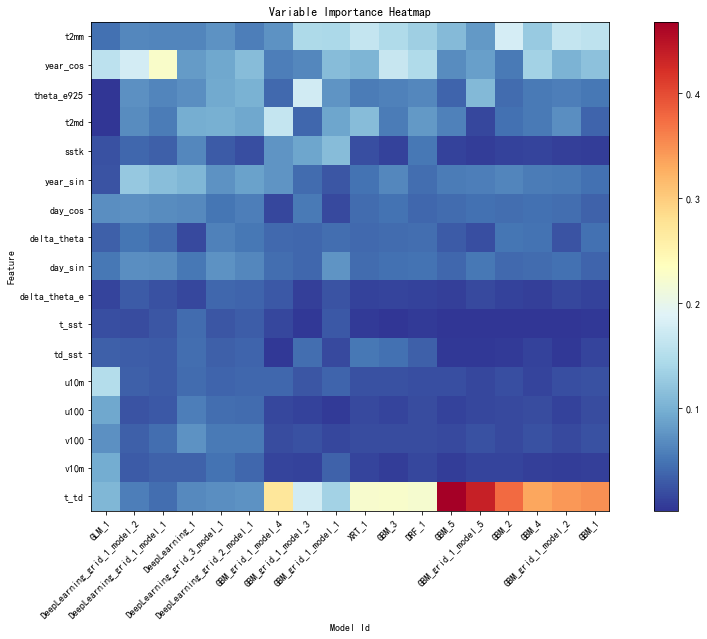

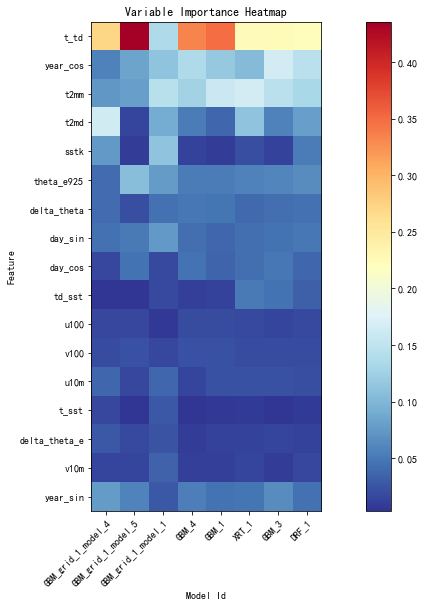

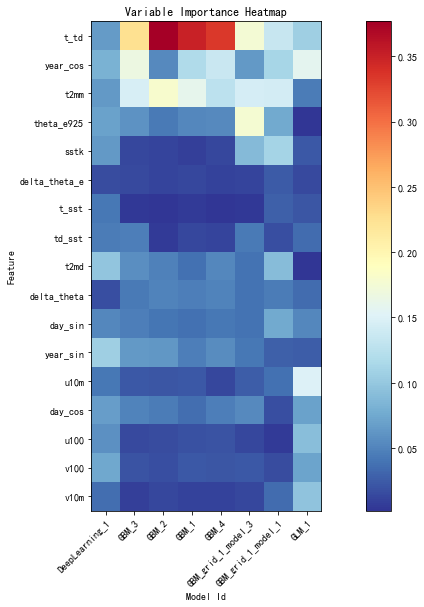

In [22]:
va_plot = aml.varimp_heatmap()

# 或者如果需要一些模型的子集，就可以使用积分排行榜的一部分，
# 例如，使用MAE作为排序指标
va_plot = h2o.varimp_heatmap(aml.leaderboard.sort("mae").head(10))

# 甚至可以使用扩展排行榜
va_plot = h2o.varimp_heatmap(
   h2o.automl.get_leaderboard(
        aml,extra_columns="training_time_ms"
    ).sort("training_time_ms").head(10))


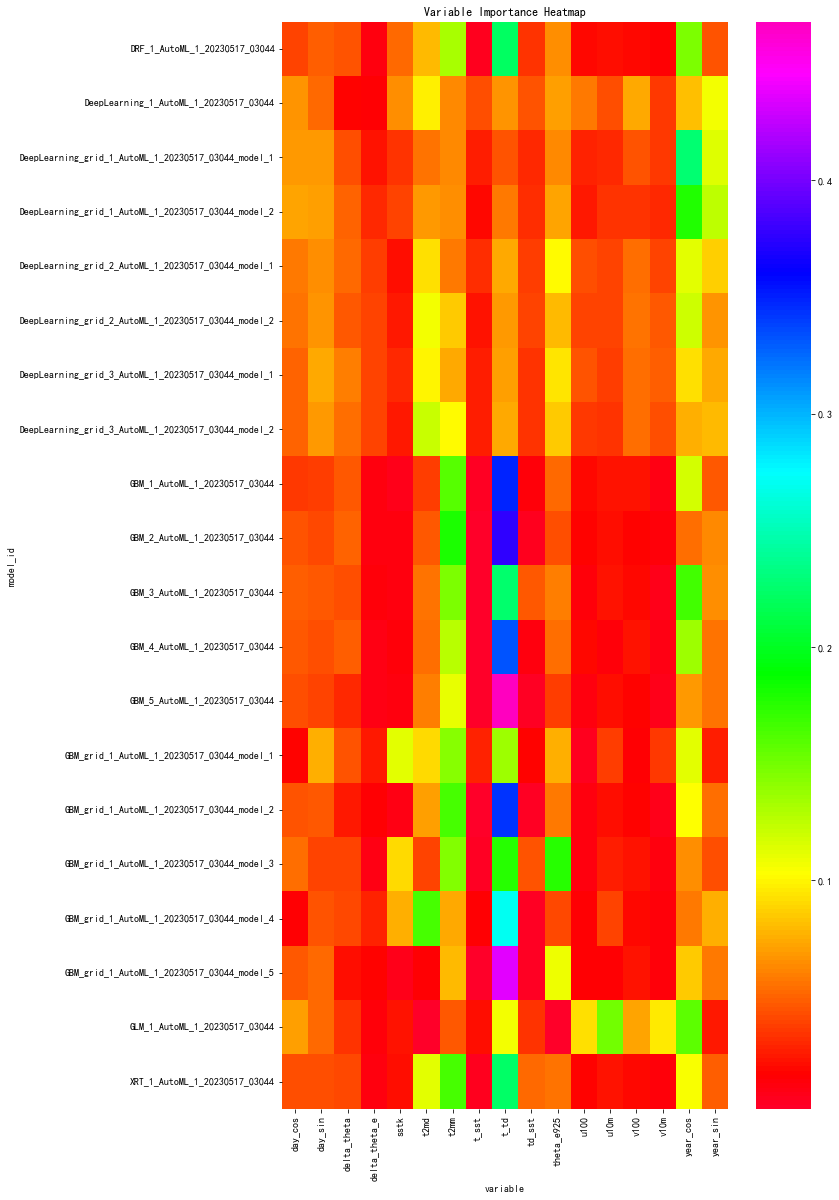

In [30]:
# 导入所需库
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 获取模型的排行榜
lb = aml.leaderboard

# 将排行榜转化为列表
model_ids = lb.as_data_frame()['model_id'].tolist()

# 提取每个模型的变量重要性
varimps = []
for model_id in model_ids:
    model = h2o.get_model(model_id)
    try:
        varimp = model.varimp(use_pandas=True)
        varimp['model_id'] = model_id
        varimps.append(varimp)
    except Exception:
        continue  # 如果模型不提供变量重要性，跳过该模型
    

# 如果没有任何模型提供变量重要性，停止
if not varimps:
    raise ValueError("No models with variable importance")

# 将变量重要性合并为一个DataFrame
varimp_df = pd.concat(varimps, axis=0)

# 对变量重要性进行归一化处理
varimp_df['scaled_importance'] = varimp_df.groupby('model_id')['scaled_importance'].transform(lambda x: x / x.sum())

# 创建变量重要性热力图
plt.figure(figsize=(10, len(varimps)))
sns.heatmap(data=varimp_df.pivot(index='model_id', columns='variable', values='scaled_importance'), cmap='gist_rainbow')
plt.title('Variable Importance Heatmap')
plt.show()


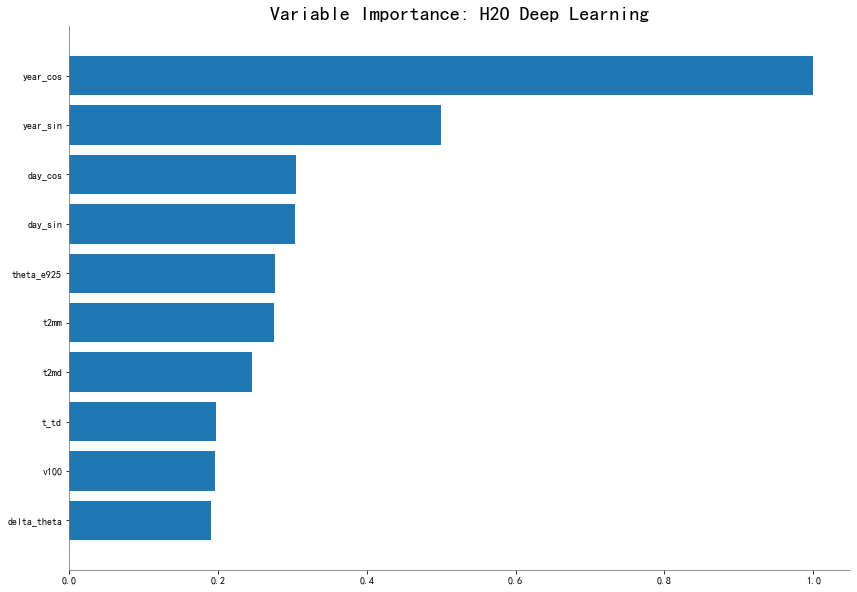

<Figure size 432x288 with 0 Axes>

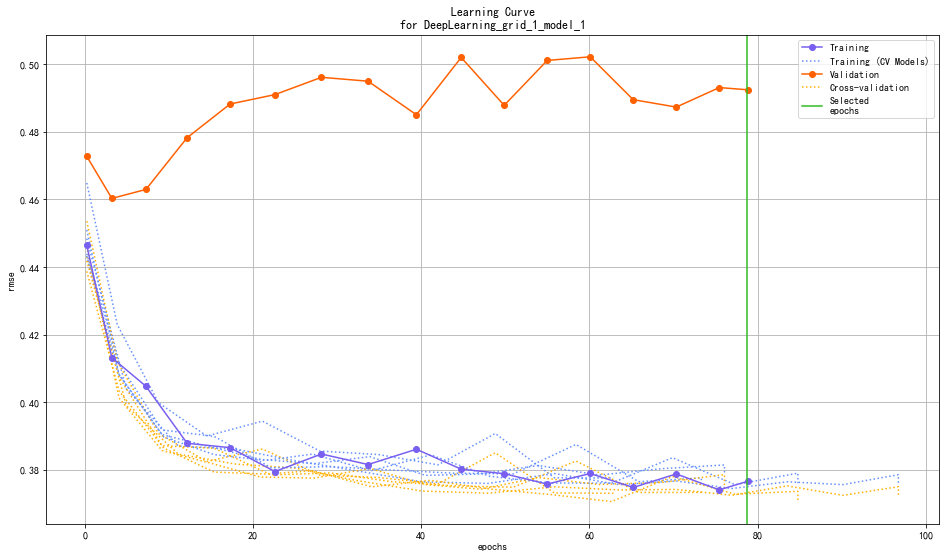

In [32]:
model = h2o.get_model('DeepLearning_grid_1_AutoML_1_20230517_03044_model_1')
ra_plot = model.varimp_plot()
learning_curve_plot = model.learning_curve_plot()




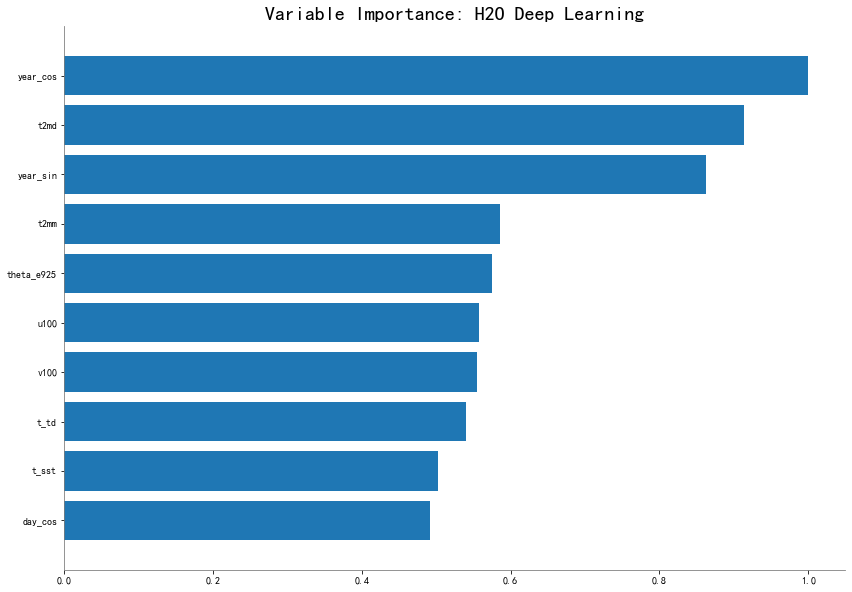

<Figure size 432x288 with 0 Axes>

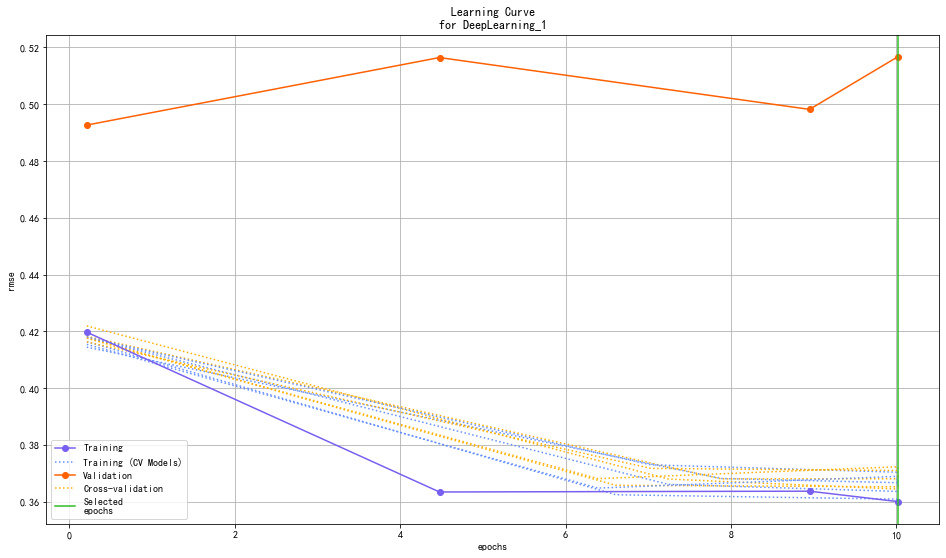

In [35]:


model = h2o.get_model("DeepLearning_1_AutoML_2_20230517_23608")
ra_plot = model.varimp_plot()
learning_curve_plot = model.learning_curve_plot()